# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [44]:
import traceback
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import WhisperForConditionalGeneration, WhisperProcessor

from utils import audio, causal

# Load Models

In [3]:
try:
    del clean_model
    del corrupted_model
    print("Models deleted!")
except:
    pass

In [4]:
MODEL_NAME = "tiny.en"

clean_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
corrupted_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
processor = WhisperProcessor.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True)
eos_id = processor.tokenizer.eos_token_id

clean_model.eval()
corrupted_model.eval()

print("Done")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Done


# Load Data

In [5]:
tedlium_path = "../tedlium"
path = f"{tedlium_path}/test.hf"

In [6]:
SELECT = 100

SEED = 1

data = load_from_disk(path).with_format("torch").shuffle(seed=SEED).select(range(SELECT))

In [45]:
dataloader = DataLoader(data)

# Register Hooks

In [7]:
activations = {}
debug_activations = {}
hooks = []
temp_hooks = []
activation_count = [0] # global

# Inference

In [8]:
def infer_with_probs(audio, model, processor):
    inputs = processor(audio, return_tensors="pt", sampling_rate=16_000)
    input_features = inputs.input_features.to(model.device)
    
    res = model.generate(input_features, return_dict_in_generate=True, output_scores=True)
    eos_probs = torch.tensor([torch.nn.Softmax(dim=0)(s.squeeze())[eos_id] for s in res["scores"]]) # get eos id for each token
    
    decoded = processor.decode(res.sequences.squeeze(), skip_special_tokens=True)
    return decoded, res, eos_probs

# Establish Clean Hooks

In [29]:
causal.reset(activations, debug_activations, hooks, temp_hooks)

In [30]:
causal.register_all_decoder_blocks(clean_model, causal.clean_hook, activations, hooks)

In [31]:
example = data[20]
wave = example["audio"]
example["text"]

'and some fish meals and then he said chicken pellets'

In [32]:
decoded, res, eos_probs = infer_with_probs(wave, clean_model, processor)
decoded

' and some fish meals and then he said chicken pellets.'

In [33]:
clean_probs = eos_probs.unsqueeze(1).repeat(1, 4) # to be used in finding effect

In [34]:
assert activations, "Activations is empty! Reverify"

# Corrupt Model and Run

In [35]:
# Verify model is sane before inserting hook
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd, p

(' and some fish meals and then he said chicken pellets.',
 tensor([0.0000e+00, 4.2728e-05, 3.6651e-06, 2.8615e-06, 2.3279e-04, 7.3043e-05,
         1.1265e-04, 1.8888e-05, 1.1879e-04, 4.4060e-04, 1.6771e-01, 9.9249e-01]))

In [36]:
embed_hook = causal.register_embedding_hook(corrupted_model, causal.corrupt_embed_hook, hooks, alpha=3)

In [37]:
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd

','

# Restore Layer

In [38]:
results = []
temp_holder = []
try:
    for token in tqdm.tqdm(range(len(activations[0])), desc="Tokens", leave=True):
        blocks = []
        for block in range(4):
            correction_hook = causal.register_at_decoder_block(corrupted_model, causal.correction_hook, block, temp_holder, block, token, activations)
            _, _, eos_prob = infer_with_probs(wave, corrupted_model, processor)
            correction_hook.remove()
            blocks.append(eos_prob[1])
        results.append(torch.stack(blocks))
except Exception as e:
    correction_hook.remove()
    traceback.print_exc()
finally:
    temp_holder.clear()
    del temp_holder

Tokens: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


In [39]:
results_total

tensor([[3.6050e-01, 1.2948e-01, 2.8952e-02, 3.8931e-01],
        [6.7585e-03, 2.7845e-04, 3.5803e-01, 2.4546e-04],
        [2.5023e-01, 2.0341e-01, 3.1830e-03, 3.6651e-06],
        [9.6784e-02, 8.2551e-01, 2.6557e-01, 3.7461e-01],
        [6.1783e-02, 4.5765e-01, 3.0878e-01, 1.4322e-03],
        [1.5646e-01, 1.8064e-01, 3.6921e-01, 4.6473e-03],
        [8.6289e-02, 5.8400e-02, 3.4982e-01, 2.7978e-02],
        [3.6256e-03, 7.7119e-03, 4.4480e-01, 6.2465e-01],
        [6.5919e-01, 1.1799e-01, 2.8387e-01, 2.9068e-01],
        [4.9678e-01, 6.0574e-01, 4.5234e-02, 4.7710e-01],
        [2.4798e-01, 2.5699e-01, 3.5190e-01, 1.4374e-01],
        [2.0811e-01, 5.0359e-01, 1.9015e-02, 7.4897e-03]])

In [40]:
results_total.shape

torch.Size([12, 4])

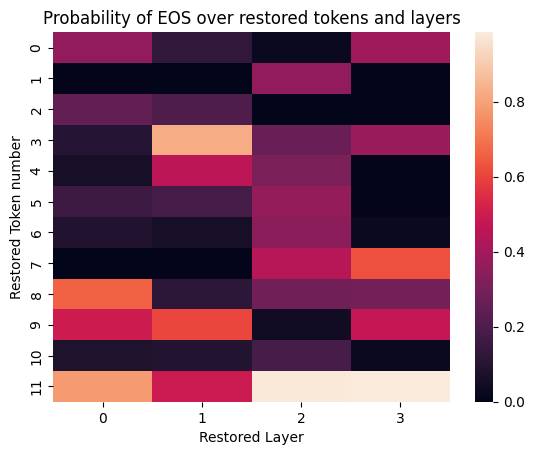

In [42]:
fig, ax = plt.subplots()
ax = sns.heatmap(torch.abs(results_total - clean_probs), ax=ax)
ax.set_xlabel("Restored Layer")
ax.set_ylabel("Restored Token number")
ax.set_title("Probability of EOS over restored tokens and layers")
plt.show()

# Aggregate over many runs

In [82]:
results = []
temp_holder = []
total_effect = direct_effect = indirect_effect = 0

ITERS = 10

pbar = tqdm.tqdm(range(10), leave=True, ncols=0, desc="Aggregate")

try:
    for i in pbar:
        results.clear()
        causal.reset(activations, debug_activations, hooks, temp_hooks)
        causal.register_all_decoder_blocks(clean_model, causal.clean_hook, activations, hooks)

        # collect activations and find clean probs
        pbar.set_postfix_str("Clean run")
        _, _, clean_probs = infer_with_probs(wave, clean_model, processor)
        clean_probs = clean_probs.unsqueeze(1).repeat(1, 4)
        assert activations, "Activations is empty! Reverify"

        # corrupt model and find corrupt probs
        pbar.set_postfix_str("Corrupted run")
        embed_hook = causal.register_embedding_hook(corrupted_model, causal.corrupt_embed_hook, hooks, alpha=3)
        _, _, corrupt_probs = infer_with_probs(wave, corrupted_model, processor)
        corrupt_probs = corrupt_probs.unsqueeze(1).repeat(1, 4)
        corrupt_probs = torch.nn.functional.pad(corrupt_probs, (0, 0, 0, clean_probs.size(0) - corrupt_probs.size(0)), value=1.0)

        # sequentially correct layers at tokens
        for token in range(len(activations[0])):
            pbar.set_postfix_str(f"Corrupted run with correction: {token + 1}/{len(activations[0])}")
            blocks = []
            for block in range(4):
                correction_hook = causal.register_at_decoder_block(corrupted_model, causal.correction_hook, block, temp_holder, block, token, activations)
                _, _, correction_probs = infer_with_probs(wave, corrupted_model, processor)
                correction_hook.remove()
                blocks.append(correction_probs[1])
            results.append(torch.stack(blocks))
        correction_probs = torch.stack(results)
        
        # TE, DE and IE
        total_effect += clean_probs - corrupt_probs
        direct_effect += clean_probs - correction_probs
        indirect_effect += correction_probs - corrupt_probs
        
except Exception as e:
    correction_hook.remove()
    traceback.print_exc()
finally:
    temp_holder.clear()

Aggregate: 100% 10/10 [01:53<00:00, 11.40s/it, Corrupted run with correction: 12/12]


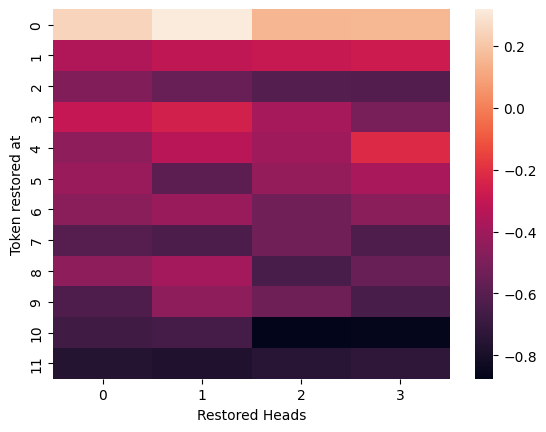

In [84]:
# IE = P(eot | corrupted with correction) - P(eot | corrupted)

ax = sns.heatmap(indirect_effect / 10)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()

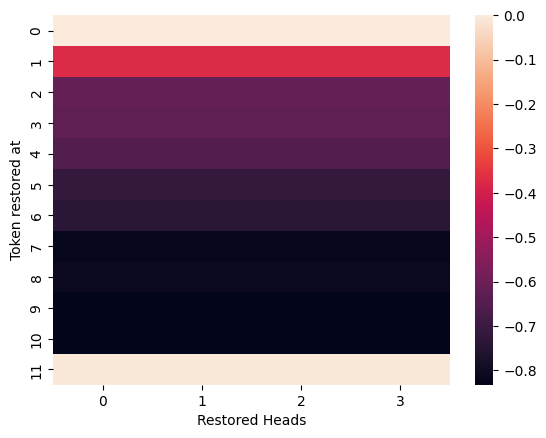

In [85]:
# TE = P(eot | no corruption) - P(eot | corrupted with correction)

ax = sns.heatmap(total_effect / 10)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()

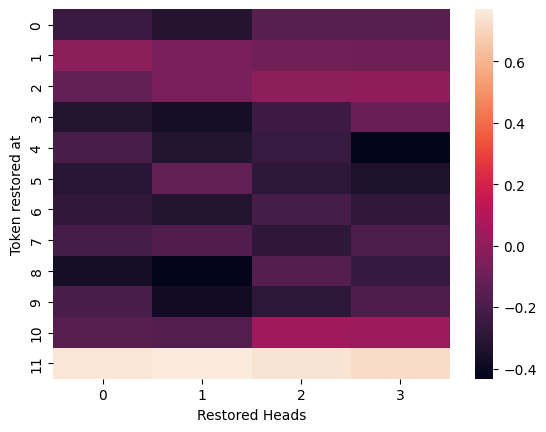

In [86]:
# IE = P(eot | corrupted with correction) - P(eot | corrupted)

ax = sns.heatmap(direct_effect / 10)
ax.set_xlabel("Restored Heads")
ax.set_ylabel("Token restored at")
plt.show()